<a href="https://colab.research.google.com/github/shranith/DeepLearningwithPytorch/blob/main/Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Localization 

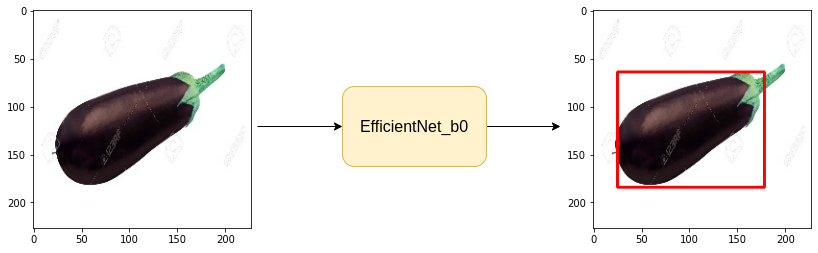

In [ ]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-y3lmexal
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-y3lmexal
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 29.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 35.45 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'CUDA'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.01
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4



In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

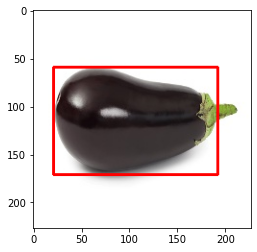

In [ ]:
row = df.iloc[184]
import os
image = cv2.imread(os.path.join(DATA_DIR, row.img_path))

img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)

bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0 ,0), 2)
plt.imshow(bnd_box_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state=42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose(
    
    [
      A.Resize(IMG_SIZE, IMG_SIZE), 
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5), 
      A.Rotate()
    ], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

In [ ]:
valid_augs = A.Compose(
    
    [
      A.Resize(IMG_SIZE, IMG_SIZE),
    ], bbox_params=A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path

    img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:

      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1)/255.0
    bbox = torch.Tensor(bbox)
    return img, bbox




In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
valset = ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f"Total examples in the trainset : {len(trainset)}")
print(f"Total examples in the validset : {len(valset)}")

Total examples in the trainset : 148
Total examples in the validset : 38


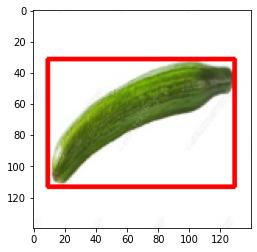

In [ ]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

validloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn 
import timm

In [ ]:
class ObjLocModel(nn.Module):

  def __init__(self, ):
    super(ObjLocModel, self).__init__()
    self.backbone = timm.create_model(MODEL_NAME, pretrained = True, num_classes=4)

  def forward(self, images, gt_bboxes=None):
    
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes




In [ ]:
model = ObjLocModel()
model.to('cuda')

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):

  total_loss = 0.0
  model.train() # Dropout layer is present

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to('cuda'), gt_bboxes.to('cuda')

    bboxes, loss = model(images, gt_bboxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)


In [ ]:
def val_fn(model, dataloader):

  total_loss = 0.0
  model.eval() # Dropout layer is absent

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to('cuda'), gt_bboxes.to('cuda')

    bboxes, loss = model(images, gt_bboxes)

    total_loss += loss.item()

  return total_loss/len(dataloader)


#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.inf

for i in range(100):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = val_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Weigths are saved")
    best_valid_loss = valid_loss
  
  print(f"Epoch {i+1} train_loss : {train_loss} valid_loss : {valid_loss} ")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 1 train_loss : 124.0481460571289 valid_loss : 185.7374064127604 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 2 train_loss : 122.53590774536133 valid_loss : 139.99889628092447 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 train_loss : 145.20266189575196 valid_loss : 531.1619262695312 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 train_loss : 136.03742218017578 valid_loss : 143.2331288655599 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 train_loss : 109.26851654052734 valid_loss : 178.7278823852539 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 train_loss : 106.98206481933593 valid_loss : 192.2401123046875 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 train_loss : 122.5985179901123 valid_loss : 423.09486897786456 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 train_loss : 121.0895839691162 valid_loss : 178.57420857747397 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 train_loss : 114.4921875 valid_loss : 321.11403401692706 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 10 train_loss : 114.34942474365235 valid_loss : 126.89379374186198 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 train_loss : 122.95474014282226 valid_loss : 530.9773763020834 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 train_loss : 97.22533988952637 valid_loss : 232.22596740722656 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 13 train_loss : 90.82873268127442 valid_loss : 111.22532399495442 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 train_loss : 101.9832160949707 valid_loss : 196.06141153971353 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 15 train_loss : 93.80595054626465 valid_loss : 104.27625020345052 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 16 train_loss : 86.82244529724122 valid_loss : 101.20726267496745 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 train_loss : 115.38024940490723 valid_loss : 286.2995910644531 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 train_loss : 92.79964981079101 valid_loss : 151.54256184895834 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 train_loss : 92.97433967590332 valid_loss : 107.2521464029948 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 train_loss : 131.44784812927247 valid_loss : 144.62606048583984 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 train_loss : 90.97610435485839 valid_loss : 347.2141825358073 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 22 train_loss : 95.38868026733398 valid_loss : 100.01830037434895 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 train_loss : 100.71181182861328 valid_loss : 138.72386169433594 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 train_loss : 119.51391296386718 valid_loss : 226.25318908691406 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 train_loss : 90.61255111694337 valid_loss : 186.98279317220053 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 26 train_loss : 89.27105293273925 valid_loss : 95.04402160644531 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 train_loss : 99.20810661315917 valid_loss : 179.45993041992188 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 train_loss : 88.88319129943848 valid_loss : 113.06860605875652 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 train_loss : 85.9193504333496 valid_loss : 227.98851521809897 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 train_loss : 110.27290267944336 valid_loss : 157.60736592610678 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 train_loss : 95.68381423950196 valid_loss : 118.48431650797527 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 32 train_loss : 90.95843658447265 valid_loss : 90.69896443684895 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 train_loss : 104.09740715026855 valid_loss : 103.48239135742188 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 train_loss : 78.16006240844726 valid_loss : 162.49142456054688 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 train_loss : 101.79036560058594 valid_loss : 185.47071329752603 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 train_loss : 112.57733459472657 valid_loss : 142.14263916015625 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 train_loss : 129.62356719970703 valid_loss : 171.68505350748697 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 train_loss : 92.82042846679687 valid_loss : 203.8707275390625 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 train_loss : 82.6271255493164 valid_loss : 235.92263793945312 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 train_loss : 78.91070785522462 valid_loss : 241.1899871826172 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 train_loss : 81.37289962768554 valid_loss : 178.13305155436197 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 train_loss : 75.41404666900635 valid_loss : 93.87420908610027 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 train_loss : 73.87093353271484 valid_loss : 104.6373799641927 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 train_loss : 91.17058563232422 valid_loss : 126.47214762369792 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 train_loss : 78.89872245788574 valid_loss : 133.73322041829428 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 train_loss : 86.3398567199707 valid_loss : 112.72257868448894 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 train_loss : 75.00474815368652 valid_loss : 160.4972890218099 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 train_loss : 71.52934036254882 valid_loss : 107.7421162923177 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 train_loss : 67.52016868591309 valid_loss : 200.53201293945312 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 train_loss : 74.6508113861084 valid_loss : 111.08886973063152 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 train_loss : 76.02984313964843 valid_loss : 123.07965850830078 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 train_loss : 72.12417068481446 valid_loss : 119.73221588134766 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 train_loss : 75.34972686767578 valid_loss : 107.58269500732422 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 train_loss : 77.86701393127441 valid_loss : 175.5502471923828 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 train_loss : 76.67538719177246 valid_loss : 142.75833384195963 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 train_loss : 78.8606029510498 valid_loss : 125.50111389160156 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 train_loss : 71.5077642440796 valid_loss : 184.2119344075521 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 train_loss : 75.08737335205078 valid_loss : 119.34841664632161 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 train_loss : 81.74018478393555 valid_loss : 181.64620463053384 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 train_loss : 89.3768497467041 valid_loss : 164.53587849934897 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 train_loss : 105.04833908081055 valid_loss : 170.9769744873047 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 train_loss : 79.49352111816407 valid_loss : 153.18440755208334 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 train_loss : 86.04746932983399 valid_loss : 165.43580118815103 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 train_loss : 81.98037528991699 valid_loss : 222.28876749674478 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 train_loss : 82.28350067138672 valid_loss : 115.26746622721355 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 train_loss : 108.11560859680176 valid_loss : 205.49756368001303 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 train_loss : 85.43131980895996 valid_loss : 170.5457000732422 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 train_loss : 85.99477996826172 valid_loss : 145.11272176106772 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 train_loss : 86.14669532775879 valid_loss : 240.8783213297526 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 train_loss : 78.35811080932618 valid_loss : 136.54832712809244 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 train_loss : 91.85007553100586 valid_loss : 146.40192159016928 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 train_loss : 60.15316467285156 valid_loss : 141.34985860188803 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 train_loss : 49.877529335021975 valid_loss : 113.65878804524739 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 train_loss : 83.40279502868653 valid_loss : 206.64293924967447 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 train_loss : 71.98849754333496 valid_loss : 154.06940205891928 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 train_loss : 99.48935775756836 valid_loss : 127.10304514567058 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 train_loss : 79.92130050659179 valid_loss : 126.37655639648438 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 train_loss : 61.02693405151367 valid_loss : 150.46924336751303 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 train_loss : 68.95836486816407 valid_loss : 140.68658447265625 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 train_loss : 67.90420875549316 valid_loss : 99.3880615234375 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 81 train_loss : 82.13809013366699 valid_loss : 89.97038269042969 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 train_loss : 90.22935638427734 valid_loss : 179.47528076171875 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 train_loss : 63.99626541137695 valid_loss : 95.18703969319661 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 train_loss : 61.746694564819336 valid_loss : 501.8546447753906 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 train_loss : 58.955130386352536 valid_loss : 138.22923024495444 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 train_loss : 53.69037094116211 valid_loss : 121.09945678710938 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weigths are saved
Epoch 87 train_loss : 71.64762878417969 valid_loss : 82.32493464152019 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 train_loss : 61.9592041015625 valid_loss : 137.51671091715494 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 train_loss : 66.17463130950928 valid_loss : 162.99866231282553 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 train_loss : 64.64185104370117 valid_loss : 224.2147216796875 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 train_loss : 53.773546409606936 valid_loss : 92.1503677368164 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 train_loss : 67.2958330154419 valid_loss : 135.87152608235678 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 train_loss : 54.16394271850586 valid_loss : 164.86577860514322 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 train_loss : 50.90248794555664 valid_loss : 113.55238596598308 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 train_loss : 63.27713241577148 valid_loss : 99.42047627766927 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 train_loss : 72.50436820983887 valid_loss : 128.33779652913412 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 train_loss : 80.77442016601563 valid_loss : 338.98094685872394 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 train_loss : 69.63112106323243 valid_loss : 90.00630950927734 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 train_loss : 71.78066711425781 valid_loss : 182.20887247721353 


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 train_loss : 75.93511543273925 valid_loss : 124.96673838297527 


#Inference

In [ ]:
import utils

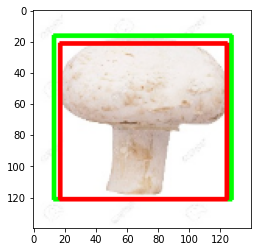

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
DEVICE = 'cuda'
with torch.no_grad():
  image, gt_bbox = valset[1]
  image = image.unsqueeze(0).to(DEVICE)
  pred_bbox = model(image)

  utils.compare_plots(image, gt_bbox, pred_bbox)